In [1]:
from models_code.utilities import create_model
from models_code.utilities import dump_results

from models_code.experiments import correlation_test_error_uncertainty
from models_code.experiments import load_notmnist
from models_code.experiments import load_omniglot
from models_code.experiments import load_cifar_bw

from models_code.experiments import not_mnist_predictions
from models_code.experiments import non_distribution
from models_code.experiments import test_eval
from models_code.experiments import softmax2d

from models_code.mnist import perform_training
from models_code.mnist import load_data
from models_code.mnist import test

from models_code.mnist import Mnist
from models_code.mnist import ISMnist
from models_code.mnist import DeVriesMnist

from models_code.utilities import load_model

import torch

import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [2]:
def set_same_seed():
    torch.manual_seed(9)
    torch.cuda.manual_seed(9)

In [3]:
batch_size = 128
log_interval = 100
epochs = 12

### DeVries

In [4]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
from torch.nn.functional import dropout
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

def encode_onehot(labels, n_classes):
    onehot = torch.FloatTensor(labels.size()[0], n_classes)
    labels = labels.data
    if labels.is_cuda:
        onehot = onehot.cuda()
    onehot.zero_()
    onehot.scatter_(1, labels.view(-1, 1), 1)
    return onehot

In [26]:
def train_devries(
        lmbda,
        epoch,
        model,
        train_loader,
        optimizer,
        loss_function,
        log_interval,
        num_batches,
        channels=1
):
    model.train()
    train_loss = 0
    accuracy = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        data = torch.autograd.Variable(data)
        data = data.cuda()
        optimizer.zero_grad()
        y_, confidence =  model(data.view(-1, channels, 32, 32))
        pred_original = torch.softmax(y_, dim=-1)
        confidence = torch.sigmoid(confidence)
        labels_onehot = torch.autograd.Variable(encode_onehot(y, 10)).cuda()

        eps = 1e-12
        pred_original = torch.clamp(pred_original, 0. + eps, 1. - eps)
        confidence = torch.clamp(confidence, 0. + eps, 1. - eps)

        b = torch.autograd.Variable(torch.bernoulli(torch.Tensor(confidence.size()).uniform_(0, 1))).cuda()
        conf = confidence * b + (1 - b)
        pred_new = pred_original * conf.expand_as(pred_original) + labels_onehot * (1 - conf.expand_as(labels_onehot))
        pred_new = torch.log(pred_new)
        
        xentropy_loss = loss_function(pred_new, torch.autograd.Variable(y).cuda())
        confidence_loss = torch.mean(-torch.log(confidence))
        
        total_loss = xentropy_loss + (lmbda * confidence_loss)

#         if 0.001 > confidence_loss.item() :
#             lmbda = lmbda / 1.01
#         elif 0.001 <= confidence_loss.item() :
#             lmbda = lmbda / 0.99

        total_loss.backward()
        train_loss += total_loss.item()
        optimizer.step()

        accuracy += accuracy_score(y, np.argmax(pred_original.cpu().data.numpy(), axis=1))
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       total_loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f} Average accuracy: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset), accuracy / num_batches))
    print(lmbda)
    return lmbda

def test(
        epoch,
        model,
        test_loader,
        optimizer,
        loss_function,
        log_interval,
        channels=1
):
    model.eval()
    test_loss = 0
    y_s = []
    ys = []
    softmax = nn.Softmax()
    for i, (data, y) in enumerate(test_loader):
        data = data.cuda()
        data = Variable(data)
        y_, aft_cauchy = model(data.view(-1, channels, 32, 32))
        y_s.append(softmax(y_).cpu().data.numpy())
        ys.append(y)

        test_loss += loss_function(y_, Variable(y).cuda()).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    print('Test accuracy: {}'.format(accuracy_score(
        np.concatenate(ys),
        np.argmax(np.concatenate(y_s), axis=1)
    )))
    
def perform_training_devries(
    epochs,
    model,
    train_loader,
    test_loader,
    optimizer,
    loss_function,
    log_interval,
    savepath,
    num_batches,
    channels=1
):
    lmbd = 0.001
    
    for epoch in range(1, epochs + 1):
        lmbd = train_devries(
            lmbd,
            epoch,
            model,
            train_loader,
            optimizer,
            loss_function,
            log_interval,
            num_batches,
            channels
        )
        test(
            epoch,
            model,
            test_loader,
            optimizer,
            loss_function,
            log_interval,
            channels
        )
    torch.save(model.state_dict(), savepath)

In [27]:
set_same_seed()
train_loader, test_loader = load_data(batch_size)

In [28]:
dv, optimizer, nll  = create_model(DeVriesMnist, loss_function=torch.nn.NLLLoss)

perform_training_devries(
    epochs,
    dv,
    train_loader,
    test_loader,
    optimizer,
    nll,
    log_interval,
    './models/mnist_lenet/dv.torch',
    60000 // batch_size + 1
)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.010391
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001846
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.000740
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.000465
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.000696
====> Epoch: 1 Average loss: 0.0019 Average accuracy: 0.8408
0.001


/home/msusik/.virtualenvs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:76: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


====> Test set loss: -0.0770
Test accuracy: 0.9711
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000836
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.000265
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.000247
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.000327
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.000178
====> Epoch: 2 Average loss: 0.0004 Average accuracy: 0.9739
0.001
====> Test set loss: -0.0722
Test accuracy: 0.9814
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000356
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.000138
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.000411
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.000204
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.000071
====> Epoch: 3 Average loss: 0.0003 Average accuracy: 0.9809
0.001
====> Test set loss: -0.0881
Test accuracy: 0.9836
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.000100
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.000133
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.000046
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.000657
Train Epoch: 4 [51200/60000 

In [29]:
test_preds, test_labels, test_probs = test_eval(dv, test_loader)

In [30]:
accuracy_score(test_labels, test_preds)

0.9887

In [31]:
log_loss(test_labels, softmax2d(test_probs[:,:10]))

0.03794622704798509

In [32]:
def test_eval_confidence(
        model,
        test_loader,
        channels=1,
        num_classes=10,
        sentiment=False,
        is_sentiment=False,
        size_factor=1
):
    model.eval()
    all_results = []
    groundtruth = []
    probs = []
    for i, (data, y) in enumerate(test_loader):
        data = data.cuda()
        data = Variable(data)
        if not sentiment and not is_sentiment:
            y_, sec_ = model(data.view(-1, channels, 32*size_factor, 32*size_factor))
        else:
            y_, sec_ = model(data.view(-1, 400))
        all_results.append(
            y_.cpu().data.numpy()[:, :num_classes].argmax(axis=1)
        )
        probs.append(sec_.cpu().data.numpy())
        groundtruth.append(y.cpu().numpy())

    if sentiment:
        return (
            sigmoid(np.concatenate(probs)),
            np.concatenate(groundtruth),
            np.concatenate(probs)
        )

    return (
        np.concatenate(all_results),
        np.concatenate(groundtruth),
        np.concatenate(probs)
    )



def not_mnist_predictions_confidence(models, not_mnist_loader, softmaxed=True):
    for model in models:
        model.eval()
    y_truth = []
    probs = []
    images = []
    softmax = torch.nn.Softmax()

    for i, (data, y) in enumerate(not_mnist_loader):
        images.append(data.cpu().numpy())
        y_s = []
        data = data.cuda()
        data = Variable(data)

        for model_ in models:
            output_, q = model_(data[:, 0, :, :].view(-1, 1, 32, 32))
            if softmaxed:
                y_ = softmax(q)
            else:
                y_ = q
            y_s.append(y_.cpu().data.numpy())
        y_truth.append(y.cpu().numpy())
        probs.append(np.stack(y_s))

    return (
        np.concatenate(y_truth),
        np.concatenate(probs, axis=1),
        images
    )


In [33]:
test_preds, test_labels, confidence = test_eval_confidence(dv, test_loader)

In [34]:
confidence.shape

(10000, 1)

In [35]:
confidence

array([[0.5595111],
       [6.019532 ],
       [0.3754807],
       ...,
       [1.7956295],
       [1.7851479],
       [2.2041385]], dtype=float32)

### Second experiment - wrong prediction detection

In [16]:
roc, ac, fpr, tpr, pr, re = correlation_test_error_uncertainty(
    lambda x: -x,
    confidence,
    test_labels
)


In [17]:
roc

0.5595514502918684

In [17]:
ac

0.9179734007698973

In [18]:
dump_results(fpr, tpr, pr, re, './results/mnist/dv.pickle')

### Third experiment - out of distribution detection

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import torch
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import numpy as np
import PIL


In [19]:
not_mnist_loader = load_notmnist(batch_size)

In [20]:
notmnist_truth, notmnist_confidence, notmnist_images = not_mnist_predictions_confidence([dv], not_mnist_loader, softmaxed=False)

In [21]:
def non_distribution(test_entropies, other_entropies, num_all, num_test):
    disting = np.concatenate([test_entropies, other_entropies])
    target = np.zeros(num_all, dtype=np.int)
    target[num_test:] = 1

    roc = roc_auc_score(target, disting)
    ap = average_precision_score(target, disting)
    fpr, tpr, _ = roc_curve(target, disting)
    pr, re, _ = precision_recall_curve(target, disting)

    return roc, ap, fpr, tpr, pr, re



In [22]:
from matplotlib import pyplot as plt

(array([ 763., 2042., 5496., 4687., 2718., 1730.,  873.,  339.,   68.,
           8.]),
 array([-0.14230931,  2.660894  ,  5.464097  ,  8.267301  , 11.070503  ,
        13.873707  , 16.67691   , 19.480114  , 22.283316  , 25.08652   ,
        27.889723  ], dtype=float32),
 <a list of 10 Patch objects>)

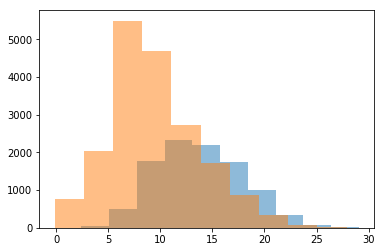

In [23]:
plt.hist(confidence, alpha=0.5)
plt.hist(notmnist_confidence[0], alpha=0.5)

In [24]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    -confidence,
    -notmnist_confidence[0],
    28724,
    10000
)


In [25]:
roc

0.7700017918179876

In [27]:
ac

0.8526299462487923

In [48]:
import numpy as np

In [ ]:
np.sigm

In [ ]:
dump_results(fpr, tpr, pr, re, './results/notmnist/is.pickle')

### Omniglot

In [ ]:
not_mnist_loader = load_omniglot(batch_size)

In [ ]:
notmnist_truth, notmnist_probs, notmnist_images = not_mnist_predictions([is_], not_mnist_loader, softmaxed=False)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_probs,
    softmax2d(test_probs)[:,10].reshape(10000,1),
    softmax2d(notmnist_probs[0])[:,10].reshape(32460,1),
    42460,
    10000
)


In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/omniglot/is.pickle')

### Cifar-bw

In [ ]:
not_mnist_loader = load_cifar_bw(batch_size)

In [ ]:
notmnist_truth, notmnist_probs, notmnist_images = not_mnist_predictions([is_], not_mnist_loader, softmaxed=False)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_probs,
    softmax2d(test_probs)[:,10].reshape(10000,1),
    softmax2d(notmnist_probs[0])[:,10].reshape(50000,1),
    60000,
    10000
)

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/cifar-bw/is.pickle')